## Load & evaluate the Faster R-CNN model
1. Load the model and prepare the function
    - 1.1 Implement on the single model
    - 1.2 Function to plot the model prediction
    - 1.3 Grad-Cam function 
    - 1.4 Example to implement the function
2. Evaluate the model
    - 2.1 Prepare the evaluation dataset according to the occlusion level
    - 2.2 Load the testset
    - 2.3 Define the IoU fucntion
    - 2.4 Prepare the evaluation functions
    - 2.5 Evaluate the model
    - 2.6 Special cases: correctly classified and detected case
    - 2.7 Special cases: wrong classification
    - 2.8 mAP calculation

### 1. Load the model and prepare the function

In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(pretrained=False)
model.load_state_dict(torch.load("fasterrcnn_opixray.pth", map_location=device))
model.to(device)
model.eval()
print("the model is loaded")


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
D:\Temp\ipykernel_9180\796307760.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will b

the model is loaded


#### 1.1 Implement on the single model

In [2]:
from PIL import Image
from torchvision import transforms

id_to_label = {
    0: 'Straight_Knife',
    1: 'Folding_Knife',
    2: 'Scissor',
    3: 'Utility_Knife',
    4: 'Multi-tool_Knife'
}

def predict_single_image(model, img_path, device, transform, threshold=0.5):

    image = Image.open(img_path).convert("RGB")
    orig = image.copy()
    image_tensor = transform(image).to(device)

    with torch.no_grad():
        outputs = model([image_tensor])[0]

    boxes = outputs['boxes'].cpu().numpy()
    labels = outputs['labels'].cpu().numpy()
    scores = outputs['scores'].cpu().numpy()

    return orig, boxes, labels, scores



In [3]:
import os
from collections import defaultdict

labeled_data_list = []
image_dir = 'dataset/train/train_image'
anno_dir = 'dataset/train/train_annotation'

label_to_id = {
    'Straight_Knife': 0,
    'Folding_Knife': 1,
    'Scissor': 2,
    'Utility_Knife': 3,
    'Multi-tool_Knife': 4
}

def is_valid_box(bbox, max_width=1225, max_height=954):
    x1, y1, x2, y2 = bbox
    return (
        x2 > x1 and y2 > y1 and
        x1 >= 0 and y1 >= 0 and
        x2 <= max_width and y2 <= max_height
    )

for txt_file in os.listdir(anno_dir):
    if txt_file.endswith('.txt'):
        txt_path = os.path.join(anno_dir, txt_file)
        with open(txt_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 6:
                    image_name = parts[0]
                    label_name = parts[1]
                    bbox = list(map(int, parts[2:6]))
                    if is_valid_box(bbox):
                        label = label_to_id[label_name]
                        image_path = os.path.join(image_dir, image_name)
                        labeled_data_list.append((image_path, label, bbox))

#### 1.2 Function to plot the model prediction

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_ground_truth(image_path, data_list):
    """
    Get the ground truth labels and bounding boxes for a given image path in the labeled_data_list
    """
    basename = os.path.basename(image_path)
    gt = []
    for img_path, label, bbox in data_list:
        if os.path.basename(img_path) == basename:
            gt.append((label, bbox))
    return gt


def plot_detection_result(orig, boxes, labels, scores, id_to_label, threshold=0.5, ground_truths=None):
    
    found = False
    plt.figure(figsize=(10, 8))
    plt.imshow(orig)
    ax = plt.gca()

    # the prediction boxes: red
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            found = True
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"Pred: {id_to_label[label]} ({score:.2f})", color='yellow', fontsize=12,
                    bbox=dict(facecolor='black', alpha=0.5))

    # the ground truth boxes: green
    if ground_truths:
        for gt_label, gt_bbox in ground_truths:
            x1, y1, x2, y2 = gt_bbox
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            ax.text(x1, y2 + 10, f"GT: {id_to_label[gt_label]}", color='white', fontsize=10,
                    bbox=dict(facecolor='green', alpha=0.6))

    # if the model is not confident about the prediction, show a message
    if not found:
        ax.text(20, 30, "No object found", color='green', fontsize=20,
                bbox=dict(facecolor='yellow', alpha=0.8))

    plt.axis('off')
    plt.title("Detection Result (Red=Prediction, Green=GT)")
    plt.show()




In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

#### 1.3 Grad-Cam function 

In [6]:
import numpy as np
from torchvision import transforms
import torchvision.transforms.functional as F
import matplotlib.patches as patches
import cv2

"""
    This Grad-CAM for Faster R-CNN is download from the internet.
"""
gradients = None
activations = None

def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def save_activation(module, input, output):
    global activations
    activations = output

def grad_cam_gt_only(model, img_path, device, transform, label_map, ground_truths, threshold=0.5):
    global gradients, activations

    image = Image.open(img_path).convert("RGB")
    orig = image.copy()
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Register hooks
    target_layer = model.backbone.body.layer4
    forward_hook = target_layer.register_forward_hook(save_activation)
    backward_hook = target_layer.register_full_backward_hook(save_gradient)

    model.eval()
    image_tensor.requires_grad = True

    outputs = model(image_tensor)
    pred = outputs[0]

    model.zero_grad()

    if len(pred['scores']) == 0 or pred['scores'].max() < threshold:
        print("No confident prediction.")

        # Create dummy loss to trigger backward
        dummy_score = outputs[0]["scores"].sum() if len(outputs[0]["scores"]) > 0 else torch.zeros(1, device=device, requires_grad=True)
        dummy_score.backward(retain_graph=True)
    else:
        best_idx = pred['scores'].argmax()
        pred['scores'][best_idx].backward(retain_graph=True)

    # Grad-CAM computation
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.squeeze(0)

    scale_factor = 1000.0
    for i in range(activations.shape[0]):
        activations[i] *= pooled_gradients[i] * scale_factor

    cam = activations.mean(dim=0).detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    cam = cv2.resize(cam, orig.size)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = np.array(orig) * 0.5 + heatmap * 0.5
    overlay = overlay.astype(np.uint8)

    # Plot with only GT box (green)
    plt.figure(figsize=(10, 8))
    plt.imshow(overlay)

    if ground_truths:
        for gt_label, gt_bbox in ground_truths:
            x1, y1, x2, y2 = gt_bbox
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), w, h, linewidth=2,
                                     edgecolor='lime', facecolor='none', linestyle='--')
            plt.gca().add_patch(rect)
            plt.text(x1, y2 + 10, f"GT: {label_map[gt_label]}", color='white', fontsize=10,
                     bbox=dict(facecolor='green', alpha=0.6))

    plt.title("Grad-CAM with Ground Truth only")
    plt.axis('off')
    plt.show()

    forward_hook.remove()
    backward_hook.remove()



#### 1.4 Example to implement the function

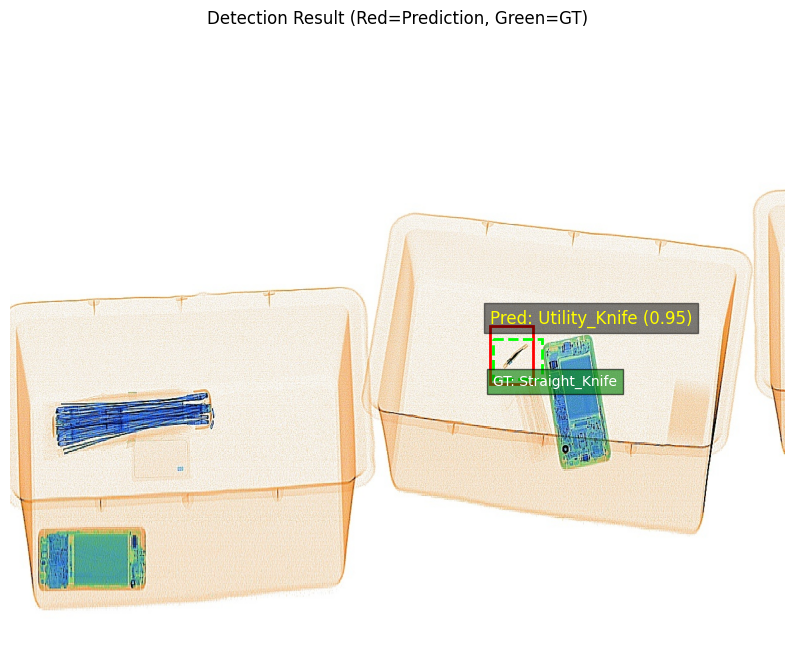

In [7]:
img_path = "dataset/train/train_image/009000.jpg"
orig, boxes, labels, scores = predict_single_image(model, img_path, device, transform)
ground_truths = get_ground_truth(img_path, labeled_data_list)

plot_detection_result(orig, boxes, labels, scores, id_to_label, threshold=0.5, ground_truths=ground_truths)

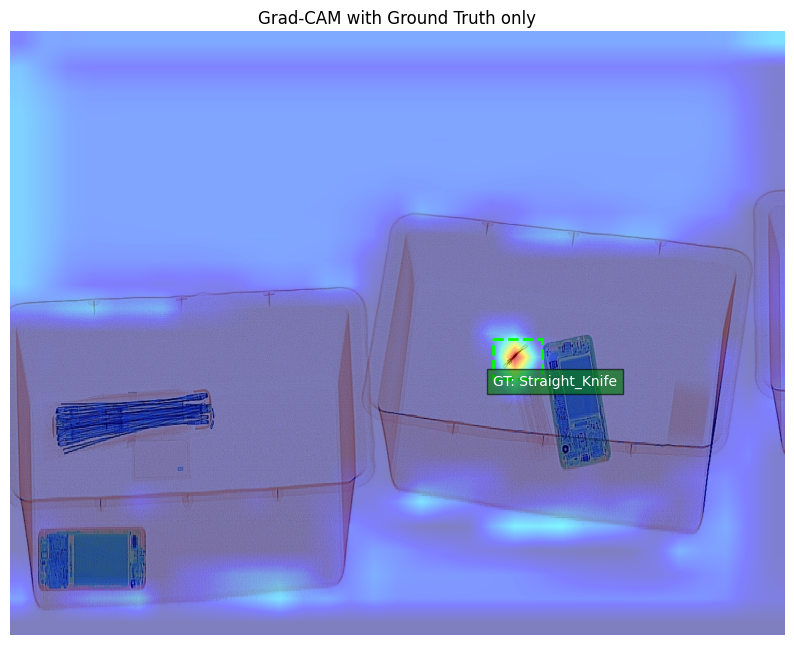

In [8]:
img_path = "dataset/train/train_image/009000.jpg"
ground_truths = get_ground_truth(img_path, labeled_data_list)
grad_cam_gt_only(model, img_path, device, transform, id_to_label, ground_truths)


### 2. Evaluate the model

#### 2.1 Prepare the evaluation dataset according to the occlusion level

In [9]:
test_id_list = []
testset_path = 'dataset/test/test_knife.txt'

with open(testset_path, 'r') as f:
    for line in f:
        test_id_list.append(line.strip())  # '010471'


In [10]:
import os

test_image_dir = "dataset/test/test_image"
test_anno_dir = "dataset/test/test_annotation"

test_data_list = []

for img_id in test_id_list:
    img_filename = f"{img_id}.jpg"
    anno_filename = f"{img_id}.txt"

    image_path = os.path.join(test_image_dir, img_filename)
    anno_path = os.path.join(test_anno_dir, anno_filename)

    with open(anno_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 6:
                _, label_str, x1, y1, x2, y2 = parts
                label = label_to_id[label_str]
                bbox = list(map(int, [x1, y1, x2, y2]))
                test_data_list.append((image_path, label, bbox))


In [11]:
print(f"the number of testset: {len(test_data_list)}")
print("the first three:")
for item in test_data_list[:3]:
    print(item)


the number of testset: 1780
the first three:
('dataset/test/test_image\\010471.jpg', 0, [587, 299, 879, 366])
('dataset/test/test_image\\010477.jpg', 0, [743, 441, 794, 535])
('dataset/test/test_image\\010478.jpg', 0, [818, 375, 896, 585])


In [12]:
def load_test_data(testset_path, test_image_dir, test_anno_dir, label_to_id):
    test_id_list = []
    with open(testset_path, 'r') as f:
        for line in f:
            test_id_list.append(line.strip())

    test_data_list = []

    for img_id in test_id_list:
        img_filename = f"{img_id}.jpg"
        anno_filename = f"{img_id}.txt"

        image_path = os.path.join(test_image_dir, img_filename)
        anno_path = os.path.join(test_anno_dir, anno_filename)

        if not os.path.exists(image_path) or not os.path.exists(anno_path):
            continue

        with open(anno_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 6:
                    _, label_str, x1, y1, x2, y2 = parts
                    label = label_to_id[label_str]
                    bbox = list(map(int, [x1, y1, x2, y2]))
                    test_data_list.append((image_path, label, bbox))

    return test_data_list


#### 2.2 Load the testset

In [13]:
from torch.utils.data import Dataset

class TestKnifeDataset(Dataset):
    def __init__(self, data_list, transform=None, resize_ratio=1.0):
        self.data_list = data_list
        self.transform = transform
        self.resize_ratio = resize_ratio  # resize ratio for the image

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label, bbox = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        if self.resize_ratio != 1.0:
            new_w = int(orig_w * self.resize_ratio)
            new_h = int(orig_h * self.resize_ratio)
            image = image.resize((new_w, new_h))

            # rescale the bounding box coordinates
            scale_x = self.resize_ratio
            scale_y = self.resize_ratio
            bbox = [
                int(bbox[0] * scale_x),
                int(bbox[1] * scale_y),
                int(bbox[2] * scale_x),
                int(bbox[3] * scale_y)
            ]

        if self.transform:
            image = self.transform(image)

        target = {
            "boxes": torch.tensor([bbox], dtype=torch.float32),
            "labels": torch.tensor([label], dtype=torch.int64)
        }

        return image, target


In [14]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [15]:
from torch.utils.data import DataLoader

test_dataset = TestKnifeDataset(test_data_list, transform=transform)

def collate_fn(batch):
    return tuple(zip(*batch))

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


#### 2.3 Define a IoU（Intersection over Union）function, to quantify the accuracy rate. IoU is usually used to evaluate the objection detection model.

In [16]:
def compute_iou(boxA, boxB):
    # boxA, boxB: [x1, y1, x2, y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou


#### 2.4 Prepare the evaluation functions


evaluate_per_class_metrics: evaluates the object detection model by calculating per-class metrics, including Precision, Recall, F1 Score, and Mean IoU, based on true positives, false positives, and false negatives across the test dataset.

compute_iou_above_threshold_ratio: computes the ratio of test samples where the predicted bounding box achieves an IoU greater than a specified threshold, providing an overall measure of the model's localization accuracy.

In [62]:
def evaluate_per_class_metrics(model, test_data_list, transform, device, num_classes=5, iou_threshold=0.5, resize_ratio=1.0):
    test_dataset = TestKnifeDataset(test_data_list, transform=transform, resize_ratio=resize_ratio)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    model.eval()
    per_class_stats = {
        i: {"TP": 0, "FP": 0, "FN": 0, "IoU_sum": 0.0, "IoU_count": 0} for i in range(num_classes)
    }

    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            pred_boxes = outputs[0]["boxes"].cpu()
            pred_labels = outputs[0]["labels"].cpu()
            pred_scores = outputs[0]["scores"].cpu()

            gt_box = targets[0]["boxes"][0].cpu()
            gt_label = targets[0]["labels"][0].cpu()

            if len(pred_scores) == 0:
                per_class_stats[gt_label.item()]["FN"] += 1
                continue

            best_idx = pred_scores.argmax()
            pred_box = pred_boxes[best_idx]
            pred_label = pred_labels[best_idx]

            iou = compute_iou(pred_box, gt_box)

            gt_c = gt_label.item()
            pred_c = pred_label.item()

            # calculte the mean iou, no matter the pred label is correct or not
            if iou >= iou_threshold:
                per_class_stats[gt_c]["IoU_sum"] += iou
                per_class_stats[gt_c]["IoU_count"] += 1

            # calculate TP, FP, FN
            if iou >= iou_threshold:
                if pred_c == gt_c:
                    per_class_stats[gt_c]["TP"] += 1
                else:
                    per_class_stats[pred_c]["FP"] += 1
                    per_class_stats[gt_c]["FN"] += 1
            else:
                per_class_stats[pred_c]["FP"] += 1
                per_class_stats[gt_c]["FN"] += 1

    results = {}
    for c in range(num_classes):
        TP = per_class_stats[c]["TP"]
        FP = per_class_stats[c]["FP"]
        FN = per_class_stats[c]["FN"]
        IoU_sum = per_class_stats[c]["IoU_sum"]
        IoU_count = per_class_stats[c]["IoU_count"]

        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        mean_iou = IoU_sum / IoU_count if IoU_count > 0 else 0.0

        results[c] = {
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "MeanIoU": mean_iou
        }

    return results


In [63]:
def compute_iou_above_threshold_ratio(model, test_data_list, transform, device, iou_threshold=0.5, resize_ratio=1.0):
    test_dataset = TestKnifeDataset(test_data_list, transform=transform, resize_ratio=resize_ratio)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    model.eval()
    total = 0
    count_above_threshold = 0

    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            pred_boxes = outputs[0]["boxes"].cpu()
            pred_scores = outputs[0]["scores"].cpu()

            gt_box = targets[0]["boxes"][0].cpu()
            total += 1

            if len(pred_scores) == 0:
                continue

            best_idx = pred_scores.argmax()
            pred_box = pred_boxes[best_idx]

            iou = compute_iou(pred_box, gt_box)
            if iou >= iou_threshold:
                count_above_threshold += 1

    ratio = count_above_threshold / total if total > 0 else 0
    return ratio


#### 2.5 Evaluate the model

Evaluates the model on all the test datasets, reporting per-class Precision, Recall, F1 score, Mean IoU, overall performance summary, and the ratio of detections with IoU greater than 0.5.

In [64]:
testset_files = [
    "dataset/test/test_knife-1.txt",
    "dataset/test/test_knife-2.txt",
    "dataset/test/test_knife-3.txt",
    "dataset/test/test_knife.txt"
]

In [29]:

for test_path in testset_files:
    test_data = load_test_data(test_path, test_image_dir="dataset/test/test_image",
                                test_anno_dir="dataset/test/test_annotation",
                                label_to_id=label_to_id)

    dataset_name = os.path.basename(test_path)
    print(f"\n Evaluation for: {dataset_name}")

    class_metrics = evaluate_per_class_metrics(model, test_data, transform, device)

    total_TP = 0
    total_FP = 0
    total_FN = 0

    for class_id, metrics in class_metrics.items():
        print(f"  Class [{id_to_label[class_id]}]: "
              f"Precision={metrics['Precision']:.4f}, "
              f"Recall={metrics['Recall']:.4f}, "
              f"F1={metrics['F1']:.4f}, "
              f"MeanIoU={metrics['MeanIoU']:.4f}")
        total_TP += metrics['TP']
        total_FP += metrics['FP']
        total_FN += metrics['FN']

    # calculte the total precision, recall and f1 score
    total_precision = total_TP / (total_TP + total_FP + 1e-6)
    total_recall = total_TP / (total_TP + total_FN + 1e-6)
    total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall + 1e-6)

    print(f"\n [Total Summary for {dataset_name}]")
    print(f"Precision = {total_precision:.4f}")
    print(f"Recall    = {total_recall:.4f}")
    print(f"F1 Score  = {total_f1:.4f}")

    # the ratio of iou > 0.5
    iou_ratio = compute_iou_above_threshold_ratio(model, test_data, transform, device)
    print(f"IoU > 0.5 ratio: {iou_ratio:.4f}")



 Evaluation for: test_knife-1.txt
  Class [Straight_Knife]: Precision=0.0000, Recall=0.0000, F1=0.0000, MeanIoU=0.6279
  Class [Folding_Knife]: Precision=0.8955, Recall=0.8738, F1=0.8845, MeanIoU=0.7143
  Class [Scissor]: Precision=0.9290, Recall=0.9812, F1=0.9544, MeanIoU=0.7618
  Class [Utility_Knife]: Precision=0.7975, Recall=0.8832, F1=0.8381, MeanIoU=0.7424
  Class [Multi-tool_Knife]: Precision=0.8679, Recall=0.9020, F1=0.8846, MeanIoU=0.7183

 [Total Summary for test_knife-1.txt]
Precision = 0.8670
Recall    = 0.8191
F1 Score  = 0.8423
IoU > 0.5 ratio: 0.8711

 Evaluation for: test_knife-2.txt
  Class [Straight_Knife]: Precision=0.0000, Recall=0.0000, F1=0.0000, MeanIoU=0.6766
  Class [Folding_Knife]: Precision=0.9023, Recall=0.8108, F1=0.8541, MeanIoU=0.7265
  Class [Scissor]: Precision=0.8897, Recall=0.9680, F1=0.9272, MeanIoU=0.7641
  Class [Utility_Knife]: Precision=0.6036, Recall=0.7614, F1=0.6734, MeanIoU=0.7203
  Class [Multi-tool_Knife]: Precision=0.8115, Recall=0.9429, 

#### 2.6 Special cases: correctly classified and detected case.

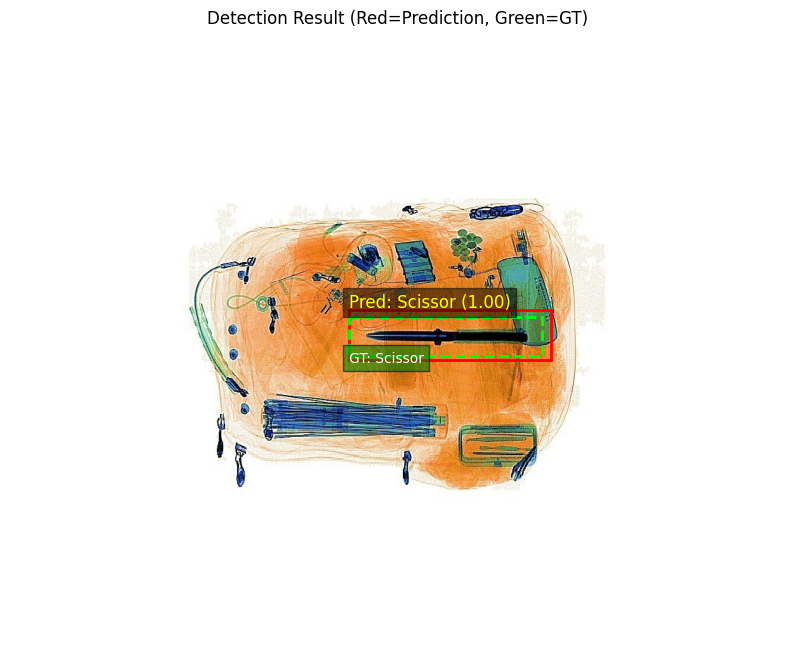

In [85]:
img_path = "dataset/test/test_image/024073.jpg"
orig, boxes, labels, scores = predict_single_image(model, img_path, device, transform)
ground_truths = get_ground_truth(img_path, test_data_list)

plot_detection_result(orig, boxes, labels, scores, id_to_label, threshold=0.5, ground_truths=ground_truths)

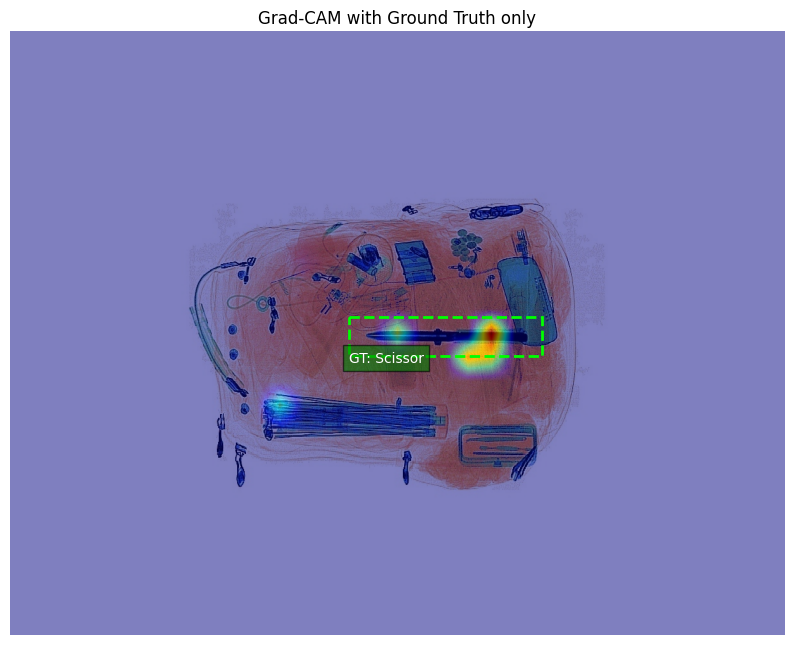

In [ ]:
ground_truths = get_ground_truth(img_path, test_data_list)

grad_cam_gt_only(model, img_path, device, transform, id_to_label, ground_truths)

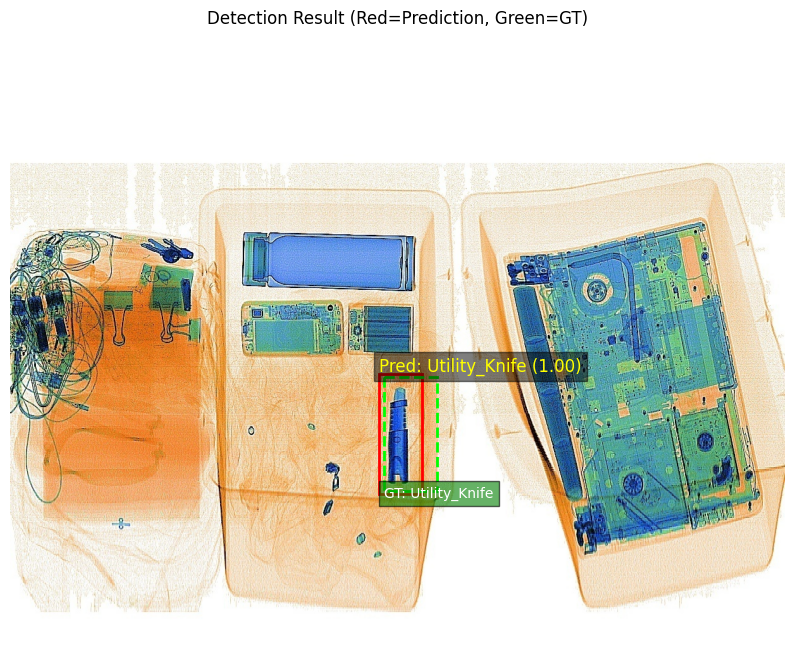

In [91]:
img_path = "dataset/test/test_image/034011.jpg"
orig, boxes, labels, scores = predict_single_image(model, img_path, device, transform)
ground_truths = get_ground_truth(img_path, test_data_list)

plot_detection_result(orig, boxes, labels, scores, id_to_label, threshold=0.5, ground_truths=ground_truths)

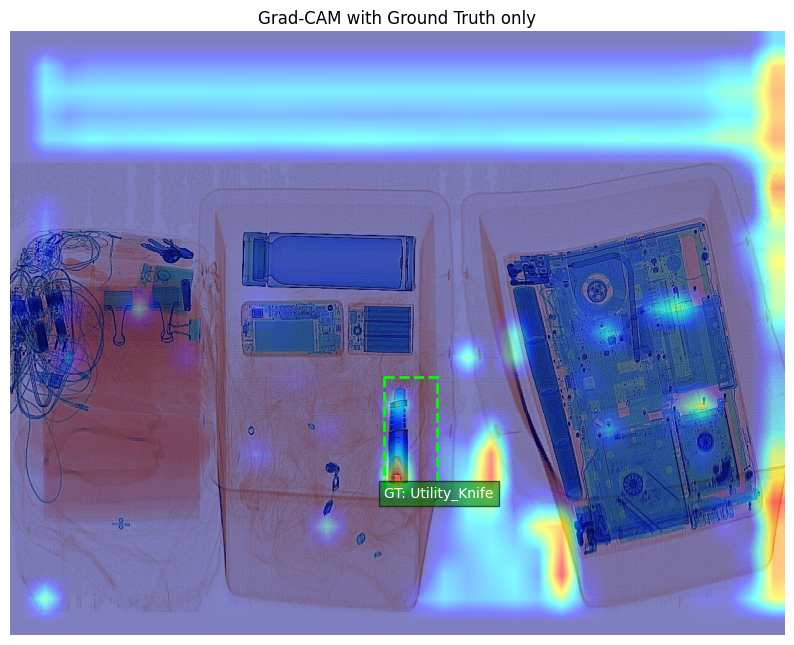

In [92]:

ground_truths = get_ground_truth(img_path, test_data_list)

grad_cam_gt_only(model, img_path, device, transform, id_to_label, ground_truths)

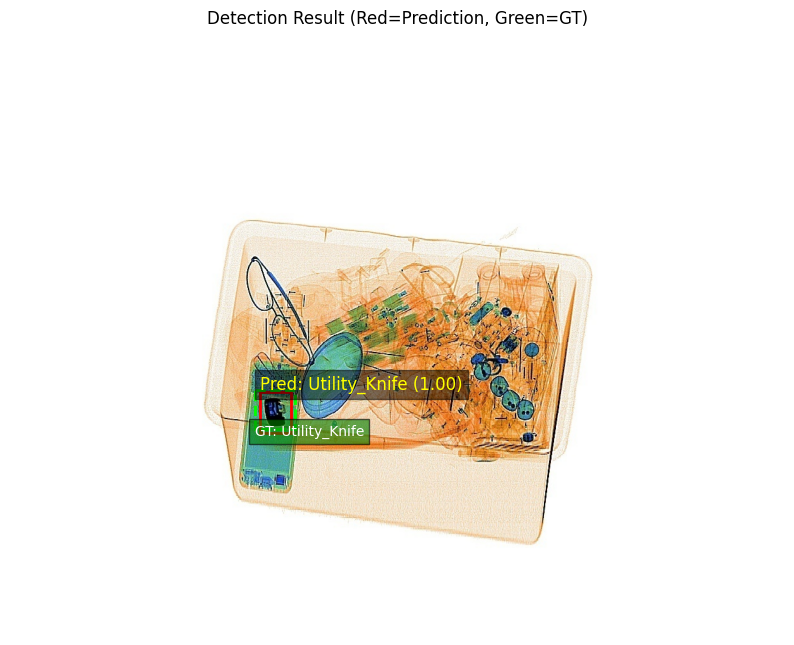

In [110]:
img_path = "dataset/test/test_image/042473.jpg"
orig, boxes, labels, scores = predict_single_image(model, img_path, device, transform)
ground_truths = get_ground_truth(img_path, test_data_list)

plot_detection_result(orig, boxes, labels, scores, id_to_label, threshold=0.5, ground_truths=ground_truths)

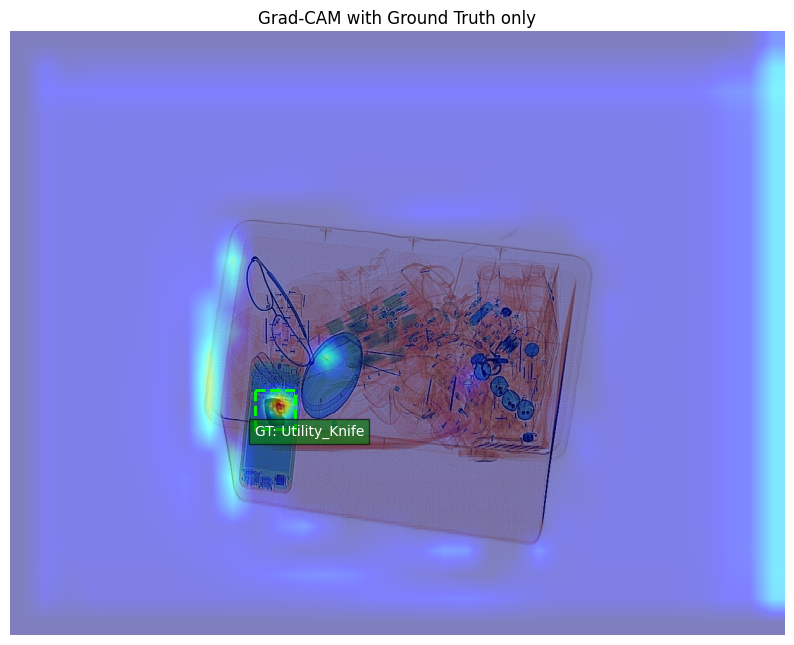

In [111]:

ground_truths = get_ground_truth(img_path, test_data_list)

grad_cam_gt_only(model, img_path, device, transform, id_to_label, ground_truths)

#### 2.7 Special cases: wrong classification(Straight_knife)

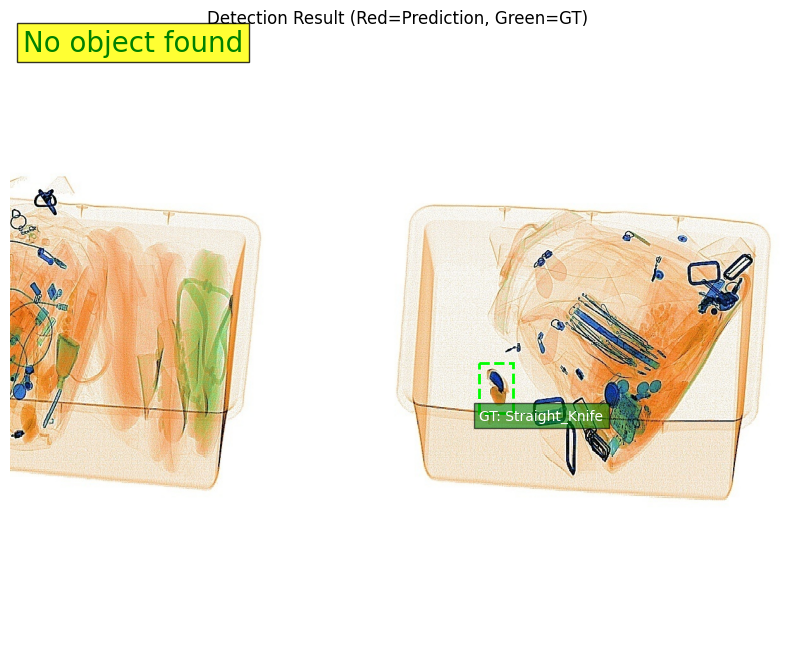

In [17]:
# case that the model do not have enough confidence to predict
img_path = "dataset/test/test_image/010470.jpg"
orig, boxes, labels, scores = predict_single_image(model, img_path, device, transform)
ground_truths = get_ground_truth(img_path, test_data_list)

plot_detection_result(orig, boxes, labels, scores, id_to_label, threshold=0.5, ground_truths=ground_truths)

No confident prediction.


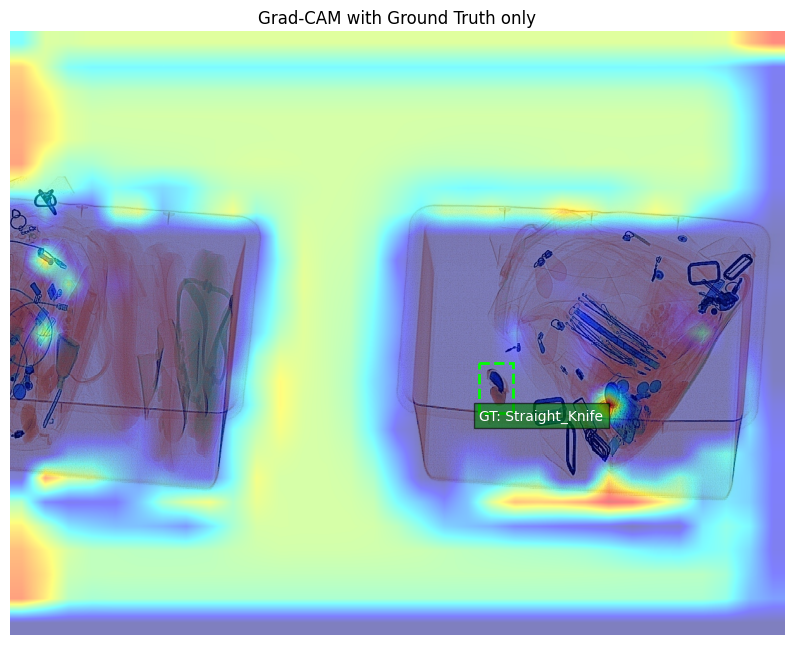

In [18]:
ground_truths = get_ground_truth(img_path, test_data_list)

grad_cam_gt_only(model, img_path, device, transform, id_to_label, ground_truths)

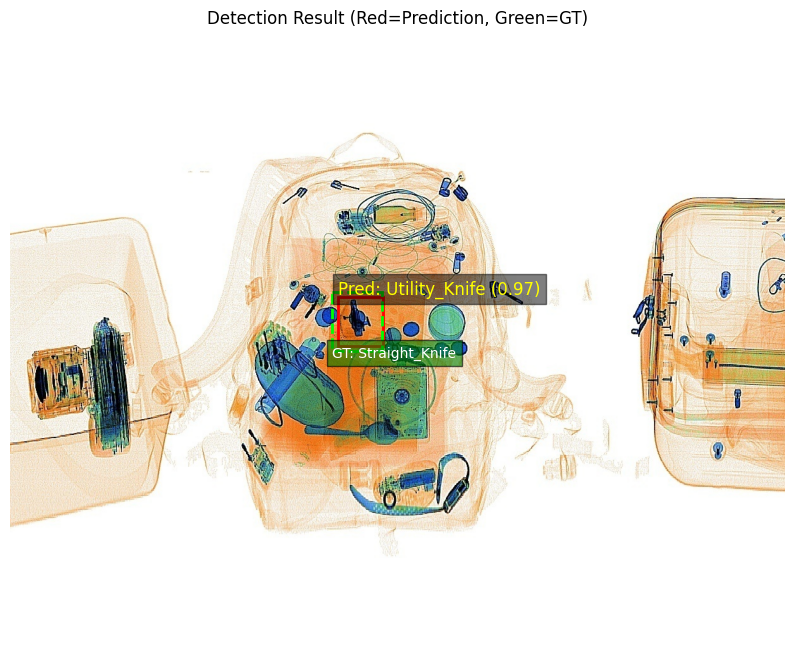

In [20]:
# case that the model correctly detects but disclassifies the object
img_path = "dataset/test/test_image/010473.jpg"
orig, boxes, labels, scores = predict_single_image(model, img_path, device, transform)
ground_truths = get_ground_truth(img_path, test_data_list)

plot_detection_result(orig, boxes, labels, scores, id_to_label, threshold=0.5, ground_truths=ground_truths)

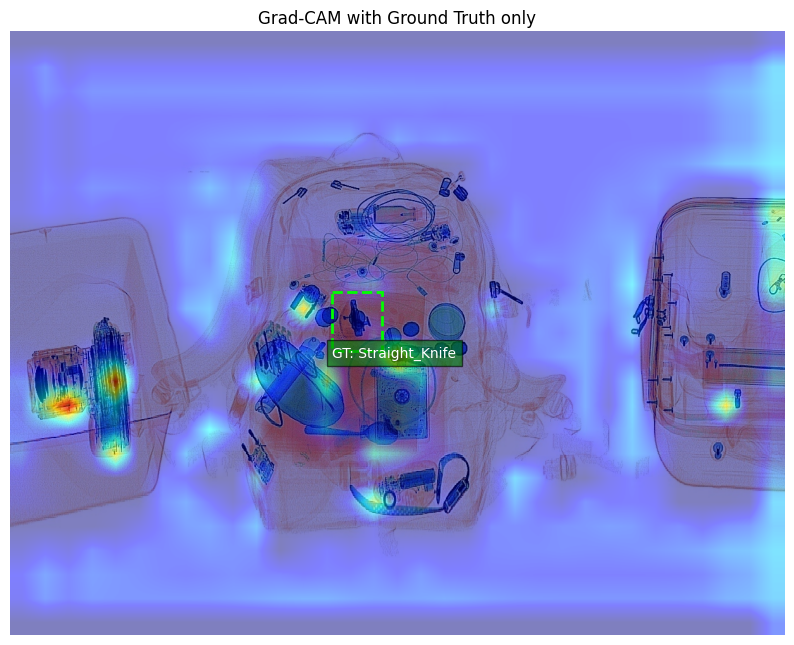

In [21]:
ground_truths = get_ground_truth(img_path, test_data_list)

grad_cam_gt_only(model, img_path, device, transform, id_to_label, ground_truths)

#### 2.8 mAP calculation

In [30]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def compute_map_for_dataset(model, test_data_list, transform, device, resize_ratio=1.0):
    from torch.utils.data import DataLoader

    test_dataset = TestKnifeDataset(test_data_list, transform=transform, resize_ratio=resize_ratio)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    model.eval()
    metric = MeanAveragePrecision(iou_type='bbox', class_metrics=True)

    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            preds = [{
                "boxes": outputs[0]["boxes"].cpu(),
                "scores": outputs[0]["scores"].cpu(),
                "labels": outputs[0]["labels"].cpu()
            }]

            gts = [{
                "boxes": targets[0]["boxes"].cpu(),
                "labels": targets[0]["labels"].cpu()
            }]

            metric.update(preds, gts)

    result = metric.compute()
    return result


In [31]:
import pycocotools
print("mAP evaluation:")

for test_path in testset_files:
    test_data = load_test_data(test_path, test_image_dir="dataset/test/test_image",
                                test_anno_dir="dataset/test/test_annotation",
                                label_to_id=label_to_id)

    dataset_name = os.path.basename(test_path)
    result = compute_map_for_dataset(model, test_data, transform, device)

    print(f"\n mAP Result for {dataset_name}")
    print(f" mAP@[0.5:0.95]: {result['map']:.4f}")
    print(f" mAP@0.5      : {result['map_50']:.4f}")
    print(f" mAP@0.75     : {result['map_75']:.4f}")


mAP evaluation:

 mAP Result for test_knife-1.txt
 mAP@[0.5:0.95]: 0.3053
 mAP@0.5      : 0.7034
 mAP@0.75     : 0.1841

 mAP Result for test_knife-2.txt
 mAP@[0.5:0.95]: 0.2945
 mAP@0.5      : 0.6820
 mAP@0.75     : 0.1866

 mAP Result for test_knife-3.txt
 mAP@[0.5:0.95]: 0.2679
 mAP@0.5      : 0.6481
 mAP@0.75     : 0.1266

 mAP Result for test_knife.txt
 mAP@[0.5:0.95]: 0.2934
 mAP@0.5      : 0.6861
 mAP@0.75     : 0.1707
